In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *
import torchvision
import torch

In [2]:
data_root_path = Path("../input")

In [3]:
train_df = pd.read_csv(data_root_path/"train.csv")
test_df = pd.read_csv(data_root_path/"sample_submission.csv")

In [4]:
transforms = get_transforms(
    do_flip=True, 
    flip_vert=True, 
    max_rotate=15.0, 
    max_lighting=0.15, 
    max_warp=0.2
)

train_imgs = ImageList.from_df(train_df, path=data_root_path/'train', folder='train')
test_imgs = ImageList.from_df(test_df, path=data_root_path/'test', folder='test')

train_imgs = (train_imgs
    .split_by_rand_pct(0.01)
    .label_from_df()
    .add_test(test_imgs)
    .transform(transforms, size=128)
    .databunch(path='.', bs=64, device= torch.device('cuda:0'))
    .normalize(imagenet_stats))

In [5]:
learn = cnn_learner(train_imgs, torchvision.models.densenet161, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 84766634.74it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


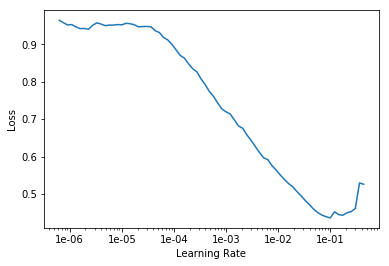

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
lr = 3e-02
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.056851,0.005663,0.002857,0.997143,00:51


KeyboardInterrupt: 

In [ ]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
test_df.has_cactus = preds.numpy()[:, 0]

In [ ]:
test_df.to_csv('submission.csv', index=False)